# BASELINE REINFORCE Algorithm

In [1]:
%load_ext autoreload
%autoreload 2

# Instalación de librería gym

https://gym.openai.com/

pip install gym

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym

# Cart Pole problem

![alt text](cart_pole.gif "Title")

In [3]:
env = gym.make("CartPole-v0")

# Train full model

In [4]:
from reinforce_alg_helper import discount_rewards, plot_episode, run_episode, score_model, get_observations_stats, get_random_episode, get_batch_data, apply_baselines, actions_to_one_hot

Using TensorFlow backend.


In [5]:
# %time states_means, states_stds = get_observations_stats(env, get_random_episode, N=10000, plot_it=False)

In [6]:
from keras.layers import Input, Dense
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
import keras.backend as K

In [7]:
def get_policy_model(env, hidden_layer_neurons, lr, baseline_weight=1, actions_weight=1):
    dimen = env.reset().shape
    num_actions = env.action_space.n
    inp = Input(shape=dimen,name="input_x")
    adv = Input(shape=[1], name="advantages")
    x = Dense(hidden_layer_neurons, 
                     activation="relu", 
                     use_bias=False,
                     kernel_initializer=glorot_uniform(seed=42),
                     name="dense_1")(inp)
    actions = Dense(num_actions, 
                       activation="softmax", 
                       kernel_initializer=glorot_uniform(seed=42),
                       use_bias=False,
                       name="actions")(x)
    baseline = Dense(1, 
                       activation="linear", 
                       kernel_initializer=glorot_uniform(seed=42),
                       name="baseline")(x)

    def custom_loss(y_true, y_pred):
        # actual: 0 predict: 0 -> log(0 * (0 - 0) + (1 - 0) * (0 + 0)) = -inf
        # actual: 1 predict: 1 -> log(1 * (1 - 1) + (1 - 1) * (1 + 1)) = -inf
        # actual: 1 predict: 0 -> log(1 * (1 - 0) + (1 - 1) * (1 + 0)) = 0
        # actual: 0 predict: 1 -> log(0 * (0 - 1) + (1 - 0) * (0 + 1)) = 0
        log_lik = y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred)
        # log_lik = categorical_crossentropy(y_true, y_pred)
        # log_lik = y_true*K.log(y_pred) + (1 - y_true) * K.log((1-y_pred))
        return K.mean(log_lik * adv, keepdims=True)
        
    model_train = Model(inputs=[inp, adv], outputs=[actions, baseline])
    losses = {'actions': custom_loss, 'baseline': 'mae'}
    model_train.compile(loss=losses, optimizer=Adam(lr), loss_weights={'actions': actions_weight, 'baseline': baseline_weight})
    
    model_predict = Model(inputs=[inp], outputs=[actions, baseline])
    return model_train, model_predict

In [8]:
def run_episode(env, model, greedy=False, gamma=.99, get_probs=False):
    in_dimen = model.input_shape[1]
    out_dimen = model.output_shape[1]
    states = np.empty(0).reshape(0, in_dimen)
    actions = np.empty(0).reshape(0,1)
    rewards = np.empty(0).reshape(0,1)
    values_func = np.empty(0).reshape(0,1)
    probs = []
    reward_sum = 0
    observation = env.reset()
    done = False
    while not done:
        # Append the observations to our batch
        state = np.reshape(observation, [1, in_dimen])
        
        predict = model.predict([state])
        if len(predict)==2:
            values_func = np.vstack([values_func, predict[1][0]])
            predict = predict[0][0]
            
        probs.append(predict)
        if greedy:
            action = np.argmax(predict)
        else:
            action = np.random.choice(range(len(predict)),p=predict)
        

        # Append the observations and outputs for learning
        states = np.vstack([states, state])
        actions = np.vstack([actions, action])

        # Determine the oucome of our action
        observation, reward, done, _ = env.step(action)
        reward_sum += reward
        rewards = np.vstack([rewards, reward])
    return_data = states, actions, rewards, reward_sum, discount_rewards(rewards, gamma)
    if len(values_func)>0:
        return_data = return_data + (values_func,)
    if get_probs:
        return_data = return_data + (probs,)
    
    return return_data

In [9]:
def get_batch_data(env, model, batch_size=50):
    batch_states = np.empty(0).reshape(0,model.input_shape[1])
    batch_actions = np.empty(0).reshape(0,1)
    discounted_rewards = np.empty(0).reshape(0,1)
    batch_probs = np.empty(0).reshape(0,2)
    value_funcs = np.empty(0).reshape(0,1)
    for i in range(batch_size):
        if len(model.output) == 2:
            states, actions, _, _, discounted_rewards_episode, value_func, probs = run_episode(env, model, get_probs=True)
        discounted_rewards = np.vstack([discounted_rewards, discounted_rewards_episode])
        batch_states = np.vstack([batch_states, states]) 
        batch_actions = np.vstack([batch_actions, actions]) 
        batch_probs = np.vstack([batch_probs, np.array(probs)])
        value_funcs = np.vstack([value_funcs, np.array(value_func)])
    if len(model.output) == 2:
        return batch_states, batch_actions, discounted_rewards, value_funcs, batch_probs
    else:
        return batch_states, batch_actions, discounted_rewards, batch_probs

In [14]:
def train_full_model(lr=0.1, max_num_episodes = 10000, episodes_batch_size = 50, training_epochs = 1, goal = 200, 
                     reset_model=True, hidden_layer_neurons = 128, verbose_period = 2, 
                     score_thres=10, states_means=None, states_stds=None,
                     model_train=None, model_predict=None, epsilon=1e-9):
    losses=[]
    if model_train is None:
        # Get model
        model_train, model_predict = get_policy_model(env, hidden_layer_neurons, lr, baseline_weight=1, actions_weight=1)
    num_episode = 0
    i = 0
    while num_episode < max_num_episodes:
        # Get batch_size episodes for training
        batch_states, batch_actions, discounted_rewards, value_funcs, batch_probs = get_batch_data(env, model_predict, episodes_batch_size)
        discounted_rewards_variance = np.mean(np.abs(discounted_rewards - discounted_rewards.mean()))
        if states_means is not None:
            batch_states = (batch_states - states_means)/states_stds
        # format data for NN
        actions_train = actions_to_one_hot(batch_actions)
        hist = model_train.fit([batch_states, discounted_rewards.squeeze() - value_funcs.squeeze()], [actions_train, discounted_rewards],
                        epochs=training_epochs, batch_size=len(batch_states), verbose=0)
        accions_loss = hist.history['actions_loss']
        mse_loss = hist.history['baseline_loss']
        losses = losses + hist.history['loss']
          
        score = score_model(model_predict, env, score_thres)
        if (i%verbose_period) == 0:
            entropy = np.mean(-np.sum(np.log(batch_probs+epsilon)*batch_probs, axis=1)/np.log(2))
            print(f'{num_episode}) loss: {losses[-1]:.2f}, actions_loss: {accions_loss[-1]:.2f}, (baseline_loss, ratio): ({mse_loss[-1]:.2f}, {(mse_loss[-1]/discounted_rewards_variance):.2f}), score: {score}, entropy: {entropy:.3f}')
        if score >= goal:
            print("Solved in {} episodes!".format(num_episode))
            break
        num_episode+=episodes_batch_size
        i+=1
    return losses, model_train, model_predict

In [15]:
losses, model_train, model_predict = train_full_model(lr=0.001, training_epochs = 1, hidden_layer_neurons = 128, 
                                                      episodes_batch_size = 1, max_num_episodes=10000, 
                                                      score_thres = 10, 
                                                      #states_means=states_means, states_stds=states_stds,
                                                      model_train=None, model_predict=None)
#                                                       model_train=model_train, model_predict=model_predict)

0) loss: 9.48, actions_loss: 3.16, (baseline_loss, ratio): (6.33, 2.24), score: 8.7, entropy: 0.998
2) loss: 9.41, actions_loss: 3.10, (baseline_loss, ratio): (6.32, 2.24), score: 9.4, entropy: 0.994
4) loss: 21.77, actions_loss: 7.32, (baseline_loss, ratio): (14.45, 2.17), score: 9.4, entropy: 0.999
6) loss: 29.99, actions_loss: 10.07, (baseline_loss, ratio): (19.92, 2.21), score: 9.1, entropy: 0.999
8) loss: 7.79, actions_loss: 2.53, (baseline_loss, ratio): (5.26, 2.21), score: 9.2, entropy: 0.991
10) loss: 19.73, actions_loss: 6.60, (baseline_loss, ratio): (13.12, 2.15), score: 9.4, entropy: 0.998
12) loss: 15.42, actions_loss: 5.17, (baseline_loss, ratio): (10.25, 2.17), score: 9.1, entropy: 0.999
14) loss: 37.51, actions_loss: 12.58, (baseline_loss, ratio): (24.93, 2.25), score: 9.1, entropy: 0.996
16) loss: 21.06, actions_loss: 7.06, (baseline_loss, ratio): (14.00, 2.17), score: 8.9, entropy: 0.998
18) loss: 32.09, actions_loss: 10.77, (baseline_loss, ratio): (21.32, 2.21), score

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(losses)

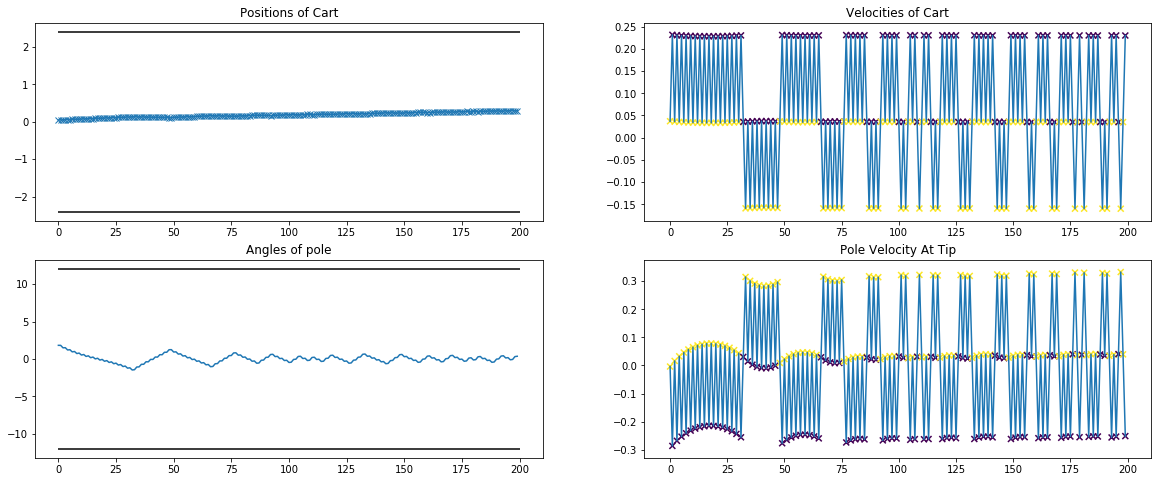

In [233]:
states, actions, rewards, reward_sum, discounted_rewards = run_episode(env, model_predict, greedy=True)
plot_episode(*states.T, actions, show_pos_thres=True)

Media de las acciones [0,1]: 0.5018760957546166
Media de rewards: 183.093


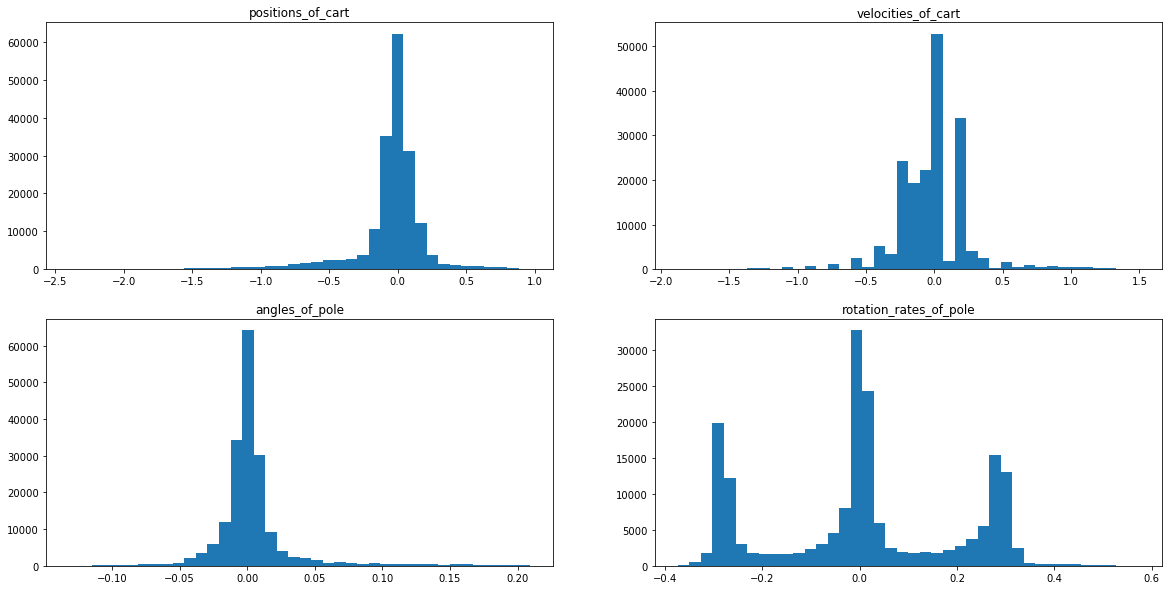

CPU times: user 3min 1s, sys: 7.07 s, total: 3min 8s
Wall time: 2min 3s


In [234]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model_predict, greedy=True), N=1000)

Media de las acciones [0,1]: 0.4960848263674372
Media de rewards: 69.601


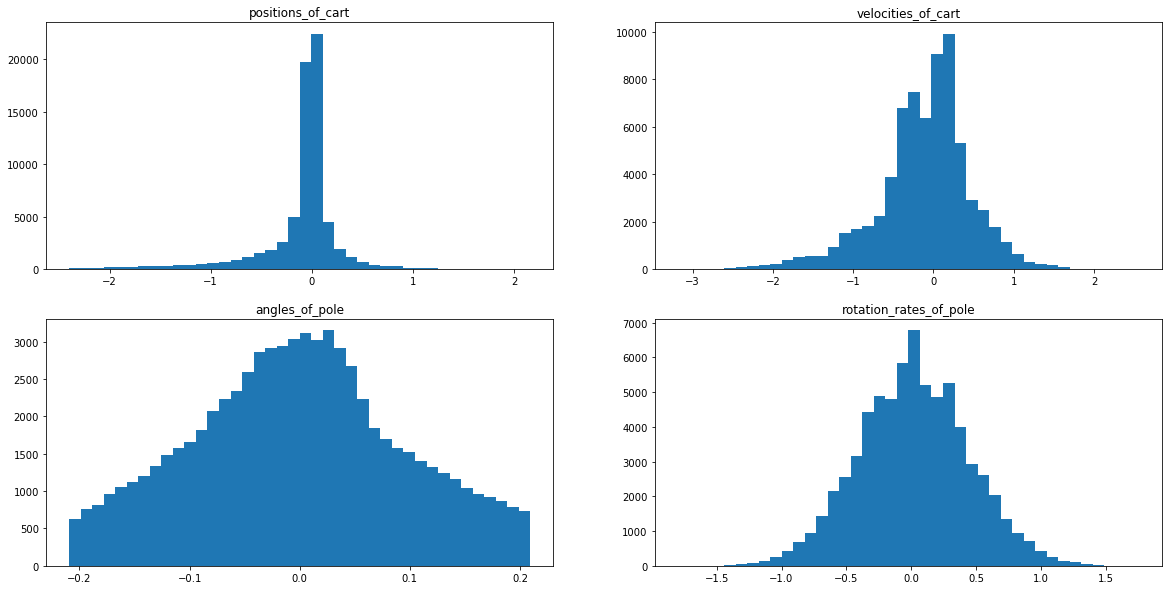

CPU times: user 1min 15s, sys: 2.88 s, total: 1min 18s
Wall time: 52.6 s


In [235]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model_predict, greedy=False), N=1000)

In [177]:
# model_predict.save('model_predict-lr_0.005-training_epochs_1-hidden_layer_neurons_128-batch_size_50.hdf5')
# model_train.save('model_train-lr_0.005-training_epochs_1-hidden_layer_neurons_128-batch_size_50.hdf5')